# Multilabel image classification

**Instructions to run code:**

Run all cells, and when prompted to authenticate by Google, just follow the instructions. The data will be downloaded as a zip file from google drive and will be unzipped in your local environment.

### Imports

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

# Authenticate
drive = None
def authenticate():
    global drive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
    authenticate()
    for fileId in fileIds:    
        downloaded = drive.CreateFile({"id": fileId[1]})
        downloaded.GetContentFile(fileId[0])

from zipfile import ZipFile
import pandas as pd
from pandas import read_csv
import re
from PIL import Image
from io import StringIO
import os

from torchvision import transforms
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from sklearn.metrics import f1_score

!pip install livelossplot
from livelossplot import PlotLosses

### Load data

In [ ]:
# specifying the zip file name 
file_name = '2020s1comp5329assignment2.zip'

try:
    _ = open(file_name, 'r')
    print('Data already downloaded!')
except:
    print('Downloading data now...')
    downloadFiles([[file_name, '1OwyhKVfuNTg-wxjPr-2xymoc8CdSDH0e']])
    print('Done downloading!')
    
    # opening the zip file in READ mode 
    with ZipFile(file_name, 'r') as zip: 
        # extracting all the files 
        print('Extracting data now...') 
        zip.extractall() 
        print('Done extracting!') 


Data already downloaded!


### Create dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (pandas DataFrame): Dataframe with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.NUM_LABELS = 19

        self.label_frame = df
        self.root_dir = os.path.join(root_dir, 'data')
        self.transform = transform

    def __len__(self):
        return len(self.label_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = self.label_frame.iloc[idx]
        img_name = os.path.join(self.root_dir, item['ImageID'])

        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        labels = [int(s) - 1 for s in item['Labels'].split(' ')]

        # for i in range(len(labels), self.NUM_LABELS):
        #     labels.append(-1)

        labels_ohe = np.zeros(self.NUM_LABELS)
        labels_ohe[labels] = 1
        
        sample = (image, torch.FloatTensor(labels_ohe))

        return sample

In [ ]:
# Transformation to apply to images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
root_dir = 'COMP5329S1A2Dataset'
train_file = os.path.join(root_dir, 'train.csv')

with open(train_file) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]

df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

# Split data into training and validation set
np.random.seed(0)
mask = np.random.rand(len(df)) < 0.85
train_df = df[mask]
val_df = df[~mask]

In [ ]:
# Create datasets
train_set = ImageDataset(train_df, root_dir, transform=transform)
train_loader = DataLoader(train_set, batch_size=10,
                        shuffle=True, num_workers=4)

val_set = ImageDataset(val_df, root_dir, transform=transform)
val_loader = DataLoader(val_set, batch_size=100,
                        shuffle=True, num_workers=4)

### Helper functions

In [ ]:
# Note that what we refer to as "accuracy" is actually f1 score!
def multilabel_accuracy(true, pred, label_threshold=0.5):
    pred = pred.cpu().detach()
    pred = pred > label_threshold
    acc = f1_score(true, pred, average='micro')
    return acc

### Model initialization

In [ ]:
%%capture

# Import pretrained resnet18 model from torchvision and freeze parameters

model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_labels = 19
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, num_labels),
    nn.Sigmoid()
)

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

### Training

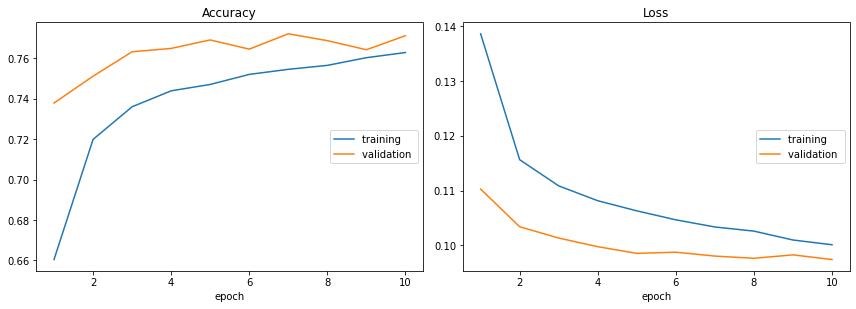

Accuracy
	training         	 (min:    0.660, max:    0.763, cur:    0.763)
	validation       	 (min:    0.738, max:    0.772, cur:    0.771)
Loss
	training         	 (min:    0.100, max:    0.139, cur:    0.100)
	validation       	 (min:    0.097, max:    0.110, cur:    0.097)


In [ ]:
epochs = 10

# utilise GPU
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')
else:
    print('using CPU')

liveloss = PlotLosses()
for ep in range(1, epochs + 1):
    logs = {}

    model.train()
    ep_loss = 0.0
    ep_acc = 0.0

    # training phase
    for step, (x, y) in enumerate(train_loader):
        true = y
        if torch.cuda.is_available():
            x = x.to('cuda')
            y = y.to('cuda')
        # set gradient to zero        
        optimizer.zero_grad()
        # calculate output
        p = model(x)
        # calculate metrics
        loss = criterion(p, y)
        acc = multilabel_accuracy(true, p)
        ep_loss += loss
        ep_acc += acc
        # back-prop
        loss.backward()
        # update parameters
        optimizer.step()
        if step % 100 == 0:
            print('\repoch: %d | step: %d | loss: %.2f | acc: %.4f'
                  % (ep, step, ep_loss/(step+1), ep_acc/(step+1)), end='')
    logs['loss'] = ep_loss/(step+1)
    logs['acc'] = ep_acc/(step+1)
            
    # validation phase
    model.eval()
    val_loss = 0
    val_acc = 0

    for step, (x, y) in enumerate(val_loader):
        true = y
        if torch.cuda.is_available():
            x = x.to('cuda')
            y = y.to('cuda')
        p = model(x)
        val_loss += criterion(p, y)
        val_acc += multilabel_accuracy(true, p)

    print('\nepoch: %d | val loss: %.2f | val acc: %.4f'
          % (ep, val_loss/(step+1), val_acc/(step+1)))
    logs['val_loss'] = val_loss/(step+1)
    logs['val_acc'] = val_acc/(step+1)

    # Update the live plot after every epoch
    liveloss.update(logs, current_step=ep)
    liveloss.send()

### Create dataset for test images

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            df (pandas DataFrame): Dataframe with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.NUM_LABELS = 19

        self.label_frame = df
        self.root_dir = os.path.join(root_dir, 'data')
        self.transform = transform

    def __len__(self):
        return len(self.label_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        item = self.label_frame.iloc[idx]
        img_name = os.path.join(self.root_dir, item['ImageID'])

        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        
        sample = (image, item['ImageID'])

        return sample

In [ ]:
test_file = os.path.join(root_dir, 'test.csv')
with open(test_file) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]

test_df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
test_set = TestImageDataset(test_df, root_dir, transform=transform)
test_loader = DataLoader(test_set, batch_size=1,
                        shuffle=True, num_workers=4)
test_data = {'ImageID': [], 'Labels': []}

### Predict labels for test images

In [ ]:
model.eval()
for step, (img, ID) in enumerate(test_loader):
    if torch.cuda.is_available():
        img = img.to('cuda')

    # calculate output
    p = model(img).cpu().detach().numpy()[0]

    labels = []
    nolabel = True
    for i in range(p.shape[0]):
        if p[i] > 0.5:
            labels.append(i+1)
            nolabel = False
    # If no label had probability > 0.5, use label with highest probability
    if nolabel:
        labels.append(np.argmax(p) + 1)

    labels = ' '.join(map(str, labels))

    test_data['ImageID'].append(ID[0])
    test_data['Labels'].append(labels)

label_df = pd.DataFrame(test_data, columns = ['ImageID', 'Labels'])

### Download csv file with predicted labels

In [ ]:
# Download csv file with predicted labels
from google.colab import files
label_df.to_csv('predicted_labels.csv', index=False) 
files.download('predicted_labels.csv')